#**Scraper**

In [ ]:
import os
import csv
import json
import time
import requests
from urllib.parse import urlencode


def gen_payload_listings(offset):
    payload = {
        "zip": "07075",
        "inventorySearchWidgetType": "AUTO",
        "searchId": "cb760f71-7c61-4a0c-a378-0e76959e5405",
        "nonShippableBaseline": "1002",
        "shopByTypes": "NEAR_BY",
        "sortDir": "ASC",
        "sourceContext": "carGurusHomePageModel",
        "distance": 75,
        "sortType": "DEAL_SCORE",
        "entitySelectingHelper.selectedEntity": "d586",
        "offset": offset,
        "maxResults": 15,
        "filtersModified": "true"
    }
    return urlencode(payload)

def gen_payload_car_details(listingID):
    payload = {
        "inventoryListing": listingID,
        "searchZip": "07075",
        "searchDistance": 75,
        "inclusionType": "undefined"
    }
    return urlencode(payload)

def handle_missing_data(jsonObj, key1, key2, key3=None):
    if key3:
        try:
            return jsonObj[key1][key2][key3]
        except:
            return None
    else:
        try:
            return jsonObj[key1][key2]
        except:
            return None

def writeCSV(data, fieldName, file_name):
    fileExists = os.path.isfile(file_name)
    with open(file_name, 'a', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldName, lineterminator='\n')
        if not fileExists:
            writer.writeheader()
        writer.writerow(data)

def fetch_url_response(url):
    r = requests.request('GET', url)
    try:
        return r.json()
    except:
        return None

if __name__ == "__main__":
    OUTPUT_FILE = "CarGuru.csv"
    scrapped_listing_ids = []
    offset = -15
    while True:
        offset += 15
        jsonObj_otr = fetch_url_response(f"https://www.cargurus.com/Cars/searchResults.action?{gen_payload_listings(offset)}")

        if not jsonObj_otr:
            break

        unique_listings = [i['id'] for i in jsonObj_otr]
        for listID in unique_listings:
            if listID not in scrapped_listing_ids:
                scrapped_listing_ids.append(listID)
                time.sleep(1)
                jsonObj = fetch_url_response(f"https://www.cargurus.com/Cars/detailListingJson.action?{gen_payload_car_details(listID)}")

                if jsonObj:
                    majorOptions = handle_missing_data(jsonObj, 'listing', 'options')
                    majorOptions = ",".join(majorOptions) if majorOptions else None

                    city, highway, combined = (None, None, None)
                    fuelEconomy = handle_missing_data(jsonObj, 'listing', 'localizedFuelEconomy')
                    if fuelEconomy:
                        for typ in fuelEconomy:
                            if "City" in typ:
                                city = typ.replace(" City","")
                            if "Highway" in typ:
                                highway = typ.replace(" Highway","")
                            if "Combined" in typ:
                                combined = typ.replace(" Combined","")

                    dataDict = {
                        'Lisitng ID': handle_missing_data(jsonObj, 'listing', 'id'),
                        'Vehicle Name': handle_missing_data(jsonObj, 'listing', 'vehicleEntityName'),
                        'Listing Title': handle_missing_data(jsonObj, 'listing', 'listingTitle'),
                        'Dealer Price': handle_missing_data(jsonObj, 'listing', 'priceString'),
                        'Price Difference': handle_missing_data(jsonObj, 'listing', 'priceDifferential'),
                        'Deal Type': handle_missing_data(jsonObj, 'listing', 'dealRatingKey'),            
                        'reviewCount': handle_missing_data(jsonObj, 'seller', 'review', 'reviewCount'),
                        'sellerRating': handle_missing_data(jsonObj, 'seller', 'review', 'averageRating'),
                        'sellerCity': handle_missing_data(jsonObj, 'seller', 'address', 'city'),
                        'sellerRegion': handle_missing_data(jsonObj, 'seller', 'address', 'region'),
                        'Distance': handle_missing_data(jsonObj, 'listing', 'distance'),
                        'Mileage': handle_missing_data(jsonObj, 'listing', 'mileageString'),
                        'Transmission': handle_missing_data(jsonObj, 'listing', 'localizedTransmission'),            
                        'Exterior Color': handle_missing_data(jsonObj, 'listing', 'localizedExteriorColor'),
                        'Interior Color': handle_missing_data(jsonObj, 'listing', 'localizedInteriorColor'),
                        'Gas Mileage City': city,
                        'Gas Mileage Highway': highway,
                        'Gas Mileage Combined': combined,            
                        'Engine': handle_missing_data(jsonObj, 'listing', 'localizedEngineDisplayName'),
                        'Drivetrain': handle_missing_data(jsonObj, 'listing', 'localizedDriveTrain'),
                        'Fuel Type': handle_missing_data(jsonObj, 'listing', 'localizedFuelType'),
                        'VIN': handle_missing_data(jsonObj, 'listing', 'vin'),
                        'Stock': handle_missing_data(jsonObj, 'listing', 'stockNumber'),
                        'Major Options': majorOptions,
                    }

                    print(dataDict, end="\n\n")
                    writeCSV(dataDict, list(dataDict.keys()), OUTPUT_FILE)

        time.sleep(1)


{'Lisitng ID': 325709814, 'Vehicle Name': '2019 Honda Civic', 'Listing Title': '2019 Honda Civic EX-L FWD - $20,390', 'Dealer Price': '$20,390', 'Price Difference': 4759.0, 'Deal Type': 'GREAT_PRICE', 'reviewCount': 56, 'sellerRating': 4.25, 'sellerCity': 'Farmingdale', 'sellerRegion': 'NY', 'Distance': '35 mi', 'Mileage': '17,729', 'Transmission': 'Continuously Variable Transmission', 'Exterior Color': 'Black', 'Interior Color': 'Black', 'Gas Mileage City': '32 MPG', 'Gas Mileage Highway': '42 MPG', 'Gas Mileage Combined': '36 MPG', 'Engine': '174 hp 1.5L I4', 'Drivetrain': 'Front-Wheel Drive', 'Fuel Type': 'Gasoline', 'VIN': '19XFC1F73KE201882', 'Stock': '800477', 'Major Options': 'Leather Seats,Sunroof/Moonroof,Adaptive Cruise Control,Alloy Wheels,Bluetooth,Backup Camera,Remote Start,Heated Seats,Android Auto,CarPlay'}

{'Lisitng ID': 324115067, 'Vehicle Name': '2022 Honda Civic', 'Listing Title': '2022 Honda Civic Touring FWD - $27,910', 'Dealer Price': '$27,910', 'Price Difference

#**Data Cleaning**

**We had to manually go into the csv file and take care of a few Nan entries that were returning error codes. Please use the below code as reference to how we pre-processed the dataset and parsed out the major options. In order to rerun the models, please start from the 'splitting the data' section below.**

In [2]:
import pandas as pd

df = pd.read_csv('CarGurus.csv')

In [3]:
df.fillna('none', inplace=True)

In [4]:
df['Price Difference'] = df['Price Difference'].replace('none', 26.77)
df['reviewCount'] = df['reviewCount'].replace('none', 64.27)
df['Dealer Price'] = df['Dealer Price'].replace('none', 19901)
df['sellerRating'] = df['sellerRating'].replace('none', 3.7)
df['Mileage'] = df['Mileage'].replace('none', 49163)
df['Gas Mileage City'] = df['Gas Mileage City'].replace('none', 29.11)
df['Gas Mileage Highway'] = df['Gas Mileage Highway'].replace('none', 38)
df['Gas Mileage Combined'] = df['Gas Mileage Combined'].replace('none', 32.6)

In [5]:
spec_chars = [",","$", " mi"]

for char in spec_chars:
    df['Dealer_Price'] = df['Dealer Price'].str.replace(char, '')
    df['Mileage'] = df['Mileage'].str.replace(char, '')
    df['Distance'] = df['Distance'].str.replace(char, '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [6]:
spec_chars = [" ", "/"]

for char in spec_chars:
    df['Major Options'] = df['Major Options'].str.replace(char, '_')

In [7]:
df['Listing_ID'] = df['Lisitng ID'].astype(int)
df['Model_Year'] = df['Vehicle Name'].str.replace(' Honda Civic', '').astype(str)
df['Dealer_Price'] = df['Dealer_Price'].astype(str)
df['Price_Difference'] = df['Price Difference'].astype(str)
df['Deal_Type'] = df['Deal Type'].astype(str)
df['Review_Count'] = df['reviewCount'].astype(str)
df['Seller_Rating'] = df['sellerRating'].astype(str)
df['Seller_City'] = df['sellerCity'].astype(str)
df['Seller_Region'] = df['sellerRegion'].astype(str)
df['Distance_Miles'] = df['Distance'].astype(str)
df['Mileage'] = df['Mileage'].astype(str)
df['Transmission'] = df['Transmission'].astype(str)
df['Exterior_Color'] = df['Exterior Color'].astype(str)
df['Interior_Color'] = df['Interior Color'].astype(str)
df['Gas_Mileage_City'] = df['Gas Mileage City'].str.replace(' MPG', '').astype(str)
df['Gas_Mileage_Highway'] = df['Gas Mileage Highway'].str.replace(' MPG', '').astype(str)
df['Gas_Mileage_Combined'] = df['Gas Mileage Combined'].str.replace(' MPG', '').astype(str)
df['Engine'] = df['Engine'].astype(str)
df['Major_Options'] = df['Major Options'].astype(str)

In [8]:
df['Model_Year'] = df['Model_Year'].astype(int)

In [9]:
df = df[df['Model_Year'] > 2011]

In [10]:
df['Age_of_Car'] = (2022-df['Model_Year'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


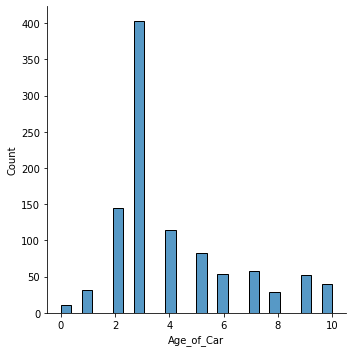

In [11]:
import seaborn as sns

sns.displot(df, x="Age_of_Car")

In [12]:
df.shape

(1022, 41)

In [13]:
df['Gas_Mileage_City'] = df['Gas_Mileage_City'].replace('none', 64.27)

In [14]:
df = df[['Listing_ID', 'Age_of_Car', 'Dealer_Price', 'Price_Difference',
               'Deal_Type', 'Review_Count', 'Seller_Rating',
               'Distance_Miles', 'Mileage', 'Transmission','Exterior_Color', 
               'Interior_Color', 'Gas_Mileage_City', 'Gas_Mileage_Highway', 
               'Gas_Mileage_Combined', 'Major_Options']]

In [15]:
new_labels = {'none':0,'OUTLIER':0, 
              'POOR_PRICE':0, 'OVERPRICED':0, 
              'OK_PRICE':1, 'FAIR_PRICE':1, 
              'GOOD_PRICE':1, 'GREAT_PRICE':1}

df['Deal_Type'] = df.Deal_Type.replace(new_labels).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
spec_chars = [",","$", " mi"]

for char in spec_chars:
    df['Dealer_Price'] = df['Dealer_Price'].str.replace(char, '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.


In [17]:
unique_options = pd.Series(list(df['Major_Options'].str.split(',', expand=True).stack().unique()))

In [18]:
options = pd.get_dummies(pd.Series(list(df['Major_Options'].str.split(',', expand=True).stack().unique())))

In [19]:
options['Listing_ID'] = df['Listing_ID']

In [20]:
master_df = pd.merge(df, options, how = 'left', left_on = 'Listing_ID', right_on = 'Listing_ID')

In [21]:
master_df['Adaptive_Cruise_Control'] = boolean_findings = master_df['Major_Options'].str.contains('Adaptive Cruise Control').astype(int)
master_df['Alloy_Wheels'] = boolean_findings = master_df['Major_Options'].str.contains('Alloy Wheels').astype(int)
master_df['Ambient_Light_Package'] = boolean_findings = master_df['Major_Options'].str.contains('Ambient Light Package').astype(int)
master_df['Android_Auto'] = boolean_findings = master_df['Major_Options'].str.contains('Android Auto').astype(int)
master_df['Appearance_Package'] = boolean_findings = master_df['Major_Options'].str.contains('Appearance Package').astype(int)
master_df['Audio_Package'] = boolean_findings = master_df['Major_Options'].str.contains('Audio Package').astype(int)
master_df['Backup_Camera'] = boolean_findings = master_df['Major_Options'].str.contains('Backup Camera').astype(int)
master_df['Blind_Spot_Monitoring'] = boolean_findings = master_df['Major_Options'].str.contains('Blind Spot Monitoring').astype(int)
master_df['Bluetooth'] = boolean_findings = master_df['Major_Options'].str.contains('Bluetooth').astype(int)
master_df['CarPlay'] = boolean_findings = master_df['Major_Options'].str.contains('CarPlay').astype(int)
master_df['Chrome_Wheels'] = boolean_findings = master_df['Major_Options'].str.contains('Chrome Wheels').astype(int)
master_df['Cold_Weather_Package'] = boolean_findings = master_df['Major_Options'].str.contains('Cold Weather Package').astype(int)
master_df['DVD_Entertainment_System'] = boolean_findings = master_df['Major_Options'].str.contains('DVD Entertainment System').astype(int)
master_df['Heated_Seats'] = boolean_findings = master_df['Major_Options'].str.contains('Heated Seats').astype(int)
master_df['LE_Package'] = boolean_findings = master_df['Major_Options'].str.contains('LE Package').astype(int)
master_df['Leather_Seats'] = boolean_findings = master_df['Major_Options'].str.contains('Leather Seats').astype(int)
master_df['Multi_Zone_Climate_Control'] = boolean_findings = master_df['Major_Options'].str.contains('Multi Zone Climate Control').astype(int)
master_df['Navigation_System'] = boolean_findings = master_df['Major_Options'].str.contains('Navigation System').astype(int)
master_df['Parking_Sensors'] = boolean_findings = master_df['Major_Options'].str.contains('Parking Sensors').astype(int)
master_df['Power_Mirror_Package'] = boolean_findings = master_df['Major_Options'].str.contains('Power Mirror Package').astype(int)
master_df['Power_Package'] = boolean_findings = master_df['Major_Options'].str.contains('Power Package').astype(int)
master_df['Premium_Package'] = boolean_findings = master_df['Major_Options'].str.contains('Premium Package').astype(int)
master_df['Premium_Wheels'] = boolean_findings = master_df['Major_Options'].str.contains('Premium Wheels').astype(int)
master_df['Remote_Start'] = boolean_findings = master_df['Major_Options'].str.contains('Remote Start').astype(int)
master_df['SE_Package'] = boolean_findings = master_df['Major_Options'].str.contains('SE Package').astype(int)
master_df['Safety_Package'] = boolean_findings = master_df['Major_Options'].str.contains('Safety Package').astype(int)
master_df['Sound_Package'] = boolean_findings = master_df['Major_Options'].str.contains('Sound Package').astype(int)
master_df['Sport_Package'] = boolean_findings = master_df['Major_Options'].str.contains('Sport Package').astype(int)
master_df['Steel_Wheels'] = boolean_findings = master_df['Major_Options'].str.contains('Steel Wheels').astype(int)
master_df['Sunroof_Moonroof'] = boolean_findings = master_df['Major_Options'].str.contains('Sunroof_Moonroof').astype(int)
master_df['none'] = boolean_findings = master_df['Major_Options'].str.contains('none').astype(int)

In [22]:
master_df['Age_of_Car'] = master_df['Age_of_Car'].astype(int)
master_df['Dealer_Price'] = master_df['Dealer_Price'].astype(float)
master_df['Price_Difference'] = master_df['Price_Difference'].astype(float)
master_df['Review_Count'] = master_df['Review_Count'].astype(float)
master_df['Seller_Rating'] = master_df['Seller_Rating'].astype(float)
master_df['Distance_Miles'] = master_df['Distance_Miles'].astype(int)
master_df['Mileage'] = master_df['Mileage'].astype(float)
master_df['Gas_Mileage_City'] = master_df['Gas_Mileage_City'].astype(float)
master_df['Gas_Mileage_Highway'] = master_df['Gas_Mileage_Highway'].astype(float)
master_df['Gas_Mileage_Combined'] = master_df['Gas_Mileage_Combined'].astype(float)

In [23]:
master_df = master_df.drop(['Major_Options'], axis = 1)

In [24]:
master_df = pd.get_dummies(master_df, prefix=['Transmission', 'Exterior_Color', 'Interior_Color'], 
               columns=['Transmission', 'Exterior_Color', 'Interior_Color'])

In [25]:
master_df.to_csv('new_df.csv')

#**Optimizing and Splitting the Data**

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.model_selection import train_test_split


df = pd.read_csv('new_df.csv')

In [27]:
correlation = df.apply(lambda x: x.corr(df.Dealer_Price))

In [28]:
df.apply(lambda x: x.corr(df.Dealer_Price)).sort_values(ascending=False).head(6)

Dealer_Price                                       1.000000
CarPlay                                            0.328099
Unnamed: 0                                         0.276907
Transmission_Continuously Variable Transmission    0.235805
Interior_Color_Black                               0.224009
Gas_Mileage_City                                   0.188423
dtype: float64

In [29]:
df.apply(lambda x: x.corr(df.Dealer_Price)).sort_values(ascending=True).head()

Age_of_Car                       -0.810752
Mileage                          -0.761331
Transmission_5-Speed Automatic   -0.443314
Price_Difference                 -0.311507
Interior_Color_Gray              -0.293707
dtype: float64

In [30]:
least_corr = correlation.between(-.05, 0.05)

In [31]:
optimized = np.where(least_corr)[0]

print(optimized)

[ 34  48  51  56  59  60  61  64  67  69  72  74  76  77  80  82  84  85
  86  89  90  91  92  93  94  95  96  97  99 100 103 104 106 107 111 113
 115 117 119 120 121 122 123 124 125 126 127 129 130 131 132 133 134 136
 138 141 146 147 148 149 150 152 153 154 155]


In [32]:
df = df.drop(df.columns[optimized], axis=1)

In [33]:
X = df.drop(['Dealer_Price'], axis = 1)
y = df['Dealer_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#**PyCarat**

In [34]:
!pip install pycaret

     |████████████████████████████████| 320 kB 9.8 MB/s 
     |████████████████████████████████| 262 kB 12.2 MB/s 
     |████████████████████████████████| 56 kB 2.9 MB/s 
     |████████████████████████████████| 16.8 MB 386 kB/s 
     |████████████████████████████████| 1.3 MB 41.2 MB/s 
     |████████████████████████████████| 6.8 MB 36.5 MB/s 
     |████████████████████████████████| 118 kB 50.4 MB/s 
     |████████████████████████████████| 167 kB 36.8 MB/s 
     |████████████████████████████████| 88 kB 5.5 MB/s 
     |████████████████████████████████| 1.7 MB 36.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0 MB 39.2 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 690 kB 47.4 MB/s 
     |████████████████████████████████| 636 kB 48.9 MB/s 
     |████████████████████

In [35]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [36]:
data = df.sample(frac=0.9, random_state=786).reset_index(drop=True)
data_unseen = df.drop(data.index).reset_index(drop=True)

In [37]:
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (920, 92)
Unseen Data For Predictions: (102, 92)


In [38]:
pip install -U jinja2


     |████████████████████████████████| 133 kB 7.7 MB/s 
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [39]:
from pycaret.regression import *

ImportError: ignored

In [ ]:
exp_reg101 = setup(data = data, target = 'Dealer_Price', session_id=123) 

In [ ]:
compare_models()

In [ ]:
ada = create_model('ada')

In [ ]:
print(ada)

In [ ]:
lightgbm = create_model('lightgbm')

In [ ]:
dt = create_model('dt')

In [ ]:
tuned_ada = tune_model('ada')

In [ ]:
print(tuned_ada)

In [ ]:
tuned_lightgbm = tune_model('lightgbm')

In [ ]:
tuned_dt = tune_model('dt')

In [ ]:
plot_model(tuned_lightgbm)

In [ ]:
plot_model(tuned_lightgbm, plot = 'error')

In [ ]:
plot_model(tuned_lightgbm, plot='feature')

In [ ]:
evaluate_model(tuned_lightgbm)

In [ ]:
predict_model(tuned_lightgbm);

In [ ]:
final_lightgbm = finalize_model(tuned_lightgbm)

In [ ]:
print(final_lightgbm)

In [ ]:
predict_model(final_lightgbm);

In [ ]:
unseen_predictions = predict_model(final_lightgbm, data=data_unseen)
unseen_predictions.head()

In [ ]:
save_model(final_lightgbm,'Final Lightgbm Model 08Feb2020')

#**Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression
import math

re_prices = LinearRegression()

re_prices.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, r2_score, explained_variance_score 

In [ ]:
y_pred_lr = re_prices.predict(X_test)

In [ ]:
print('Regression model performance evaluation')
print('R2: ', r2_score(y_test, y_pred_lr))
print('MAE: ', mean_absolute_error(y_test, y_pred_lr))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, y_pred_lr)))
print('Max error: ', max_error(y_test, y_pred_lr))

#**kNN**

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_ = scaler.fit_transform(X)

X_rescaled = pd.DataFrame(X_, columns=X.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_rescaled, y, test_size=0.3, random_state=1)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

In [ ]:
print('kNN model performance evaluation')
print('R2: ', r2_score(y_test, y_pred_knn))
print('MAE: ', mean_absolute_error(y_test, y_pred_knn))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, y_pred_knn)))
print('Max error: ', max_error(y_test, y_pred_knn))

In [ ]:
from sklearn.model_selection import cross_val_score
max_K = 50
cv_scores = [ ]

for K in range(1,max_K):
    knn = KNeighborsRegressor(n_neighbors = K)
    scores = cross_val_score(knn,X_train,y_train.values.ravel(),cv = 5,scoring = "r2")
    cv_scores.append(scores.mean())

In [ ]:
sns.lineplot(x=range(1,max_K), y=cv_scores)

In [ ]:
print('Max value R2: ', max(cv_scores), ' Optimal k: ' , cv_scores.index(max(cv_scores))+1)

#**Random Forest**

In [ ]:
from sklearn import tree

In [ ]:
dt_model = tree.DecisionTreeRegressor(min_samples_leaf=5, max_depth=3)

dt_model.fit(X_train,y_train)

In [ ]:
y_pred = dt_model.predict(X_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model  = RandomForestRegressor(max_depth=5, random_state=0)
rf_model.fit(X_train,y_train)

y_pred_rf = rf_model.predict(X_test)

In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

In [ ]:
print('Random forest model performance evaluation')
print('R2: ', r2_score(y_test, y_pred_rf))
print('MAE: ', mean_absolute_error(y_test, y_pred_rf))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, y_pred_rf)))
print('Max error: ', max_error(y_test, y_pred_rf))

#**Boosted Tree**

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

bt_model = AdaBoostRegressor(n_estimators=100)

bt_model.fit(X_train,y_train)

y_pred_bt = bt_model.predict(X_test)

In [ ]:
print('Boosted tree model performance evaluation')
print('R2: ', r2_score(y_test, y_pred_bt))
print('MAE: ', mean_absolute_error(y_test, y_pred_bt))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, y_pred_bt)))
print('Max error: ', max_error(y_test, y_pred_bt))

#**xgBoost**

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
xg_reg.fit(X_train,y_train)

y_pred_xgb = xg_reg.predict(X_test)

In [ ]:
print('XGBoost model performance evaluation')
print('R2: ', r2_score(y_test, y_pred_xgb))
print('MAE: ', mean_absolute_error(y_test, y_pred_xgb))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('Max error: ', max_error(y_test, y_pred_xgb))

#**Keras**

In [ ]:
# Rescaling the data

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Training dataset shape: ', X_train.shape)
print('Test dataset shape: ', X_test.shape)

In [ ]:
# Defining model architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [ ]:
# Training the model

model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

In [ ]:
losses = pd.DataFrame(model.history.history)

In [ ]:
losses.plot()

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

y_pred_keras = model.predict(X_test)

print('R2: ', r2_score(y_test, y_pred_keras))
print('MAE: ', mean_absolute_error(y_test,y_pred_keras))
print('RMSE: ', np.sqrt(mean_squared_error(y_test,y_pred_keras)))
print('Max error: ', max_error(y_test, y_pred_keras))

#**Model Performance**

We ran our dataset through Linear Regression, kNN, Random Forest, Boosted Tree, xgBoost, and Keras models to see which returned the best r2 score. From the list, below are the returned r2 values:

**Linear Regression:** 0.76

**kNN:** 0.59

**Random Forest:** 0.81

**Boosted Tree:** 0.81

**xgBoost:** -1.10

**Keras:** 0.75

From these metrics we can see that Random Forest and Boosted Tree seem to be the best models for our application of the data.